In [1]:
import os,sys
sys.path.append('../src/python/')

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing._encoders import _BaseEncoder

from skl2onnx.sklapi import CastTransformer
from models.onnxlib import ONNXConverter, ONNXPredictorCLF, ONNXPredictorREGR

# Loading the dataset:

In [2]:
data = pd.read_csv('../data/raw/abalone.csv')
data.columns = [x.replace(' ', '_').lower() for x in data.columns]
data

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
whole_weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
shucked_weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
viscera_weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
shell_weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


# Data preparation:

In [6]:
TARGET_COL = 'rings'

In [7]:
X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
print('Train:', x_train.shape[0], 'samples', x_train.shape[1], 'columns')
print('Test:', x_test.shape[0], 'samples', x_test.shape[1], 'columns')

Train: 2923 samples 8 columns
Test: 1254 samples 8 columns


# Pre-processing Pipeline:

In [10]:
# Creating the transformation:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [11]:
# Feature Encoding:
numeric_features = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']
categorical_features  = ['sex']
passthrough_features = []
all_features_ = (numeric_features + categorical_features
                 + passthrough_features)

features_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features),
#                                                    ('passthrough', 'passthrough', passthrough_features),
                                                  ],
                                     remainder='drop')

In [12]:
# Feature Construction:
features_creator = PolynomialFeatures(2, include_bias=False)

In [13]:
# Feature Selection:
regr_select = LinearRegression()
features_selector = SelectFromModel(regr_select)

In [14]:
preprocessor = Pipeline([('feature_encoding', features_encoder),
                         ('feature_creation', features_creator),
                         ('feature_selection', features_selector),
                        ])

In [15]:
# Columns dropped by preprocessor:
columns_to_drop = data.columns[~np.isin(data.columns, all_features_)]
columns_to_drop

Index(['rings'], dtype='object')

In [16]:
x_train_transf = preprocessor.fit_transform(x_train, y_train)
pd.DataFrame(x_train_transf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.608108,0.290182,1.0,0.0,0.0,0.608108,0.00000,0.000000,0.290182,0.000000,0.000000,1.0,0.0,0.0
1,0.479730,0.105245,0.0,1.0,0.0,0.000000,0.47973,0.000000,0.000000,0.105245,0.000000,0.0,1.0,0.0
2,0.513514,0.108608,0.0,0.0,1.0,0.000000,0.00000,0.513514,0.000000,0.000000,0.108608,0.0,0.0,1.0
3,0.175676,0.010760,0.0,0.0,1.0,0.000000,0.00000,0.175676,0.000000,0.000000,0.010760,0.0,0.0,1.0
4,0.695946,0.339610,1.0,0.0,0.0,0.695946,0.00000,0.000000,0.339610,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,0.560811,0.171486,1.0,0.0,0.0,0.560811,0.00000,0.000000,0.171486,0.000000,0.000000,1.0,0.0,0.0
2919,0.804054,0.364156,1.0,0.0,0.0,0.804054,0.00000,0.000000,0.364156,0.000000,0.000000,1.0,0.0,0.0
2920,0.587838,0.163416,0.0,0.0,1.0,0.000000,0.00000,0.587838,0.000000,0.000000,0.163416,0.0,0.0,1.0
2921,0.675676,0.346335,0.0,0.0,1.0,0.000000,0.00000,0.675676,0.000000,0.000000,0.346335,0.0,0.0,1.0


In [17]:
x_encoded_test = pd.DataFrame(preprocessor.transform(x_test))
x_encoded_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.716216,0.282448,0.0,0.0,1.0,0.000000,0.0,0.716216,0.000000,0.0,0.282448,0.0,0.0,1.0
1,0.695946,0.259583,0.0,0.0,1.0,0.000000,0.0,0.695946,0.000000,0.0,0.259583,0.0,0.0,1.0
2,0.655405,0.204438,1.0,0.0,0.0,0.655405,0.0,0.000000,0.204438,0.0,0.000000,1.0,0.0,0.0
3,0.756757,0.361466,1.0,0.0,0.0,0.756757,0.0,0.000000,0.361466,0.0,0.000000,1.0,0.0,0.0
4,0.540541,0.157364,0.0,0.0,1.0,0.000000,0.0,0.540541,0.000000,0.0,0.157364,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,0.722973,0.365165,0.0,0.0,1.0,0.000000,0.0,0.722973,0.000000,0.0,0.365165,0.0,0.0,1.0
1250,0.290541,0.033961,1.0,0.0,0.0,0.290541,0.0,0.000000,0.033961,0.0,0.000000,1.0,0.0,0.0
1251,0.608108,0.279085,1.0,0.0,0.0,0.608108,0.0,0.000000,0.279085,0.0,0.000000,1.0,0.0,0.0
1252,0.817568,0.412912,1.0,0.0,0.0,0.817568,0.0,0.000000,0.412912,0.0,0.000000,1.0,0.0,0.0


# Training the model into the main pipeline:

In [18]:
# Training the model and getting the results:
lr_regr = LinearRegression()
lr_regr.fit(x_train_transf, y_train)

LinearRegression()

In [19]:
model_full = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', lr_regr)])

In [20]:
y_train_pred = model_full.predict(x_train)
y_test_pred = model_full.predict(x_test)

# Model evaluation:

In [21]:
print(f'MAE (train): {mean_absolute_error(y_train, y_train_pred)} MAE (test): {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE (train): {mean_squared_error(y_train, y_train_pred)} MSE (test): {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 score (train): {r2_score(y_train, y_train_pred)} R2 score (test): {r2_score(y_test, y_test_pred)}')

MAE (train): 1.8405426787547041 MAE (test): 1.8077277711323765
MSE (train): 6.5928522841472805 MSE (test): 6.242340136562999
R2 score (train): 0.37130517892669934 R2 score (test): 0.38526713823373615


# Converting to ONNX format

In [22]:
onnx_conv = ONNXConverter(preprocessor, lr_regr)

In [23]:
x_train

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
2830,F,0.525,0.430,0.135,0.8435,0.4325,0.1800,0.1815
925,I,0.430,0.325,0.100,0.3645,0.1575,0.0825,0.1050
3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450
547,M,0.205,0.155,0.045,0.0425,0.0170,0.0055,0.0155
2259,F,0.590,0.465,0.160,1.1005,0.5060,0.2525,0.2950
...,...,...,...,...,...,...,...,...
3444,F,0.490,0.400,0.115,0.5690,0.2560,0.1325,0.1450
466,F,0.670,0.550,0.190,1.3905,0.5425,0.3035,0.4000
3092,M,0.510,0.395,0.125,0.5805,0.2440,0.1335,0.1880
3772,M,0.575,0.465,0.120,1.0535,0.5160,0.2185,0.2350


In [24]:
onnx_conv.convert_initial_types(x_train, y_train, columns_to_drop, show_types=True)


Initial types preprocessing (8):
sex StringTensorType(shape=[None, 1])
length FloatTensorType(shape=[None, 1])
diameter FloatTensorType(shape=[None, 1])
height FloatTensorType(shape=[None, 1])
whole_weight FloatTensorType(shape=[None, 1])
shucked_weight FloatTensorType(shape=[None, 1])
viscera_weight FloatTensorType(shape=[None, 1])
shell_weight FloatTensorType(shape=[None, 1])

Initial types estimator (1):
x_values FloatTensorType(shape=[None, 14])


In [25]:
prep_filename = './preprocessor_baseline.onnx'
estimator_filename = './model_baseline.onnx'

onnx_conv.dump_models(prep_filename=prep_filename,estimator_filename=estimator_filename)

./preprocessor_baseline.onnx saved successfully.
./model_baseline.onnx saved successfully.


# Loading the ONNX files and performing predictions:

In [26]:
onnx_pred = ONNXPredictorREGR(prep_filename, estimator_filename)
onnx_pred.run_predictions(x_test)

array([       0., -4194304.,        0., ...,        0.,        0.,
              0.], dtype=float32)

In [27]:
y_test_onnx = onnx_pred.output_value

In [28]:
y_test_pred

array([11.765625, 11.625   , 11.890625, ..., 10.      , 12.296875,
        9.15625 ])

In [29]:
y_test_onnx

array([       0., -4194304.,        0., ...,        0.,        0.,
              0.], dtype=float32)

In [30]:
print(sum(y_test_pred == y_test_onnx), 'equal results')
print(sum(y_test_pred != y_test_onnx), 'different results')

0 equal results
1254 different results


In [31]:
value_diffs = y_test_pred - y_test_onnx
value_diffs

array([1.17656250e+01, 4.19431562e+06, 1.18906250e+01, ...,
       1.00000000e+01, 1.22968750e+01, 9.15625000e+00])

In [32]:
abs(value_diffs).mean()

2174090.2387111243

In [33]:
abs(value_diffs).max()

12582922.5703125

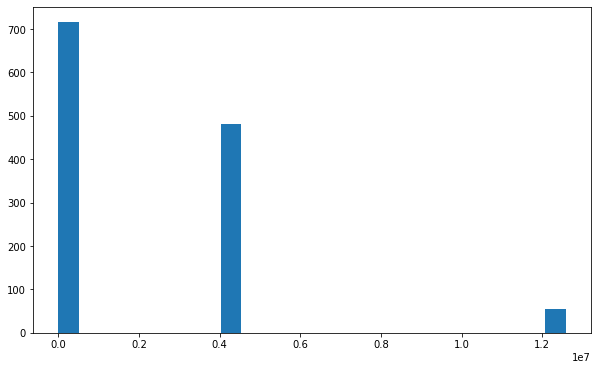

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(abs(value_diffs), bins=25)
plt.show()

In [35]:
# # Deleting all files created:
# os.remove(onnx_pred.prep_filename)
# os.remove(onnx_pred.estimator_filename)